In [1]:
# Import modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.svm import SVR
from collections import Counter
from matplotlib.colors import Normalize
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn.utils import shuffle
print('All modules successfully imported.')

All modules successfully imported.


In [2]:
# Define variable sets
predictor_all = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'may_1_ultraBlue', 'may_2_blue', 'may_3_green', 'may_4_red', 'may_5_nearInfrared', 'may_6_shortInfrared1', 'may_7_shortInfrared2', 'may_evi2', 'may_nbr', 'may_ndmi', 'may_ndsi', 'may_ndvi', 'may_ndwi', 'june_1_ultraBlue', 'june_2_blue', 'june_3_green', 'june_4_red', 'june_5_nearInfrared', 'june_6_shortInfrared1', 'june_7_shortInfrared2', 'june_evi2', 'june_nbr', 'june_ndmi', 'june_ndsi', 'june_ndvi', 'june_ndwi', 'july_1_ultraBlue', 'july_2_blue', 'july_3_green', 'july_4_red', 'july_5_nearInfrared', 'july_6_shortInfrared1', 'july_7_shortInfrared2', 'july_evi2', 'july_nbr', 'july_ndmi', 'july_ndsi', 'july_ndvi', 'july_ndwi', 'august_1_ultraBlue', 'august_2_blue', 'august_3_green', 'august_4_red', 'august_5_nearInfrared', 'august_6_shortInfrared1', 'august_7_shortInfrared2', 'august_evi2', 'august_nbr', 'august_ndmi', 'august_ndsi', 'august_ndvi', 'august_ndwi', 'september_1_ultraBlue', 'september_2_blue', 'september_3_green', 'september_4_red', 'september_5_nearInfrared', 'september_6_shortInfrared1', 'september_7_shortInfrared2', 'september_evi2', 'september_nbr', 'september_ndmi', 'september_ndsi', 'september_ndvi', 'september_ndwi']
predictor_metrics = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'may_2_blue', 'may_evi2', 'may_nbr', 'may_ndmi', 'may_ndsi', 'may_ndvi', 'may_ndwi', 'june_2_blue', 'june_evi2', 'june_nbr', 'june_ndmi', 'june_ndsi', 'june_ndvi', 'june_ndwi', 'july_2_blue', 'july_evi2', 'july_nbr', 'july_ndmi', 'july_ndsi', 'july_ndvi', 'july_ndwi', 'august_2_blue', 'august_evi2', 'august_nbr', 'august_ndmi', 'august_ndsi', 'august_ndvi', 'august_ndwi', 'september_2_blue', 'september_evi2', 'september_nbr', 'september_ndmi', 'september_ndsi', 'september_ndvi', 'september_ndwi']
predictor_midsummer = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'july_1_ultraBlue', 'july_2_blue', 'july_3_green', 'july_4_red', 'july_5_nearInfrared', 'july_6_shortInfrared1', 'july_7_shortInfrared2', 'july_evi2', 'july_nbr', 'july_ndmi', 'july_ndsi', 'july_ndvi', 'july_ndwi', 'strata']
predictor_raw = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'may_1_ultraBlue', 'may_2_blue', 'may_3_green', 'may_4_red', 'may_5_nearInfrared', 'may_6_shortInfrared1', 'may_7_shortInfrared2', 'june_1_ultraBlue', 'june_2_blue', 'june_3_green', 'june_4_red', 'june_5_nearInfrared', 'june_6_shortInfrared1', 'june_7_shortInfrared2', 'july_1_ultraBlue', 'july_2_blue', 'july_3_green', 'july_4_red', 'july_5_nearInfrared', 'july_6_shortInfrared1', 'july_7_shortInfrared2', 'august_1_ultraBlue', 'august_2_blue', 'august_3_green', 'august_4_red', 'august_5_nearInfrared', 'august_6_shortInfrared1', 'august_7_shortInfrared2', 'september_1_ultraBlue', 'september_2_blue', 'september_3_green', 'september_4_red', 'september_5_nearInfrared', 'september_6_shortInfrared1', 'september_7_shortInfrared2']
zero_variable = ['zero']
strata = ['strata']
cover = ['cover']
retain_variables = ['project', 'siteID', 'siteCode', 'methodSurvey', 'methodCover']
coordinates = ['POINT_X', 'POINT_Y']
all_variables = retain_variables + coordinates + predictor_metrics + zero_variable + strata + cover
print('Variable sets loaded.')

Variable sets loaded.


In [3]:
# Define input file
input_file = 'E:/VegetationEcology/Data_Harmonization/Project_GIS/Data_Output/speciesData/betula_nana.csv'
# Create data frame of input data
input_data = pd.read_csv(input_file)
input_data.reset_index()
# Convert values to floats
input_data[predictor_all + cover + coordinates] = input_data[predictor_all + cover + coordinates].astype(float)
# Convert values to integers
input_data[strata + zero_variable] = input_data[strata + zero_variable].astype(int)
# Shuffle the data
input_data = shuffle(input_data)

In [4]:
# Subset the data to just presences
presence_data = input_data[input_data[cover[0]] >= 1]
presence_data = presence_data[presence_data['methodCover'] == 'Quantitative']

In [5]:
# Split the X and y data
X = presence_data[predictor_metrics]
y = presence_data[cover[0]]
# Shuffle data
X, y = shuffle(X, y)

In [6]:
# Create an xgboost regressor with default settings and calculate negative mean squared error performance
xgbRegressor = XGBRegressor()
baseline_xgb = cross_val_score(xgbRegressor, X, y, scoring='neg_mean_squared_error', cv=5).mean()

In [7]:
# Display the mean squared error of the untuned xgboost regressor
np.sqrt(baseline_xgb*-1)

13.614306116832767

In [8]:
# Compute a baseline from random forest
rfRegressor = RandomForestRegressor(n_estimators=500, criterion='mse', bootstrap=True, oob_score=False, n_jobs=1)
baseline_rf = cross_val_score(rfRegressor, X, y, scoring='neg_mean_squared_error', cv=5).mean()

In [9]:
# Display the mean squared error of the random forest regressor
np.sqrt(baseline_rf*-1)

13.060939406820639

In [10]:
# Create the hyperparameter search domain
domain=[{'name': 'max_depth', 'type': 'discrete', 'domain': (1, 100)},
        {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 5000)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (0, 10)},
        {'name': 'max_delta_step', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1)},
        {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.3, 1.0)},
        {'name': 'colsample_bylevel', 'type': 'continuous', 'domain': (0.3, 1.0)},
        {'name': 'reg_alpha', 'type': 'continuous', 'domain': (1, 10)},
        {'name': 'reg_lamda', 'type': 'continuous', 'domain': (1, 10)},
        {'name': 'scale_pos_weight', 'type': 'continuous', 'domain': (1, 5)}]

In [11]:
# Define an optimization objective function
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBRegressor(max_depth=int(parameters[0]),
                     learning_rate=parameters[1],
                     n_estimators=int(parameters[2]),
                     silent=True,
                     objective='reg:linear',
                     booster='gbtree',
                     n_jobs=1,
                     gamma=parameters[3],
                     min_child_weight=int(parameters[4]),
                     max_delta_step=int(parameters[5]),
                     subsample=parameters[6],
                     colsample_bytree=parameters[7],
                     colsample_bylevel=parameters[8],
                     reg_alpha=parameters[9],
                     reg_lambda=parameters[10],
                     scale_pos_weight=parameters[11]),
        X, y, scoring='neg_mean_squared_error', cv=5).mean()
    score = np.array(score)
    return score

In [12]:
optimizer = BayesianOptimization(f=cv_score,
                                 domain=domain,
                                 model_type='GP',
                                 initial_design_numdata=5,
                                 initial_design_type='random',
                                 acquisition_type ='EI',
                                 exact_feval=False,
                                 maximize=True)

In [13]:
# Run 10 iterations
optimizer.run_optimization(max_iter=20)

In [14]:
# Display the lowest RMSE score achieved
np.sqrt(np.amin(optimizer.Y))

13.173318970118004

In [15]:
# Select best set of hyperparameters for the regressor
regressor_parameters = optimizer.X[np.argmin(optimizer.Y)]
# Display best hyperparameters for the regressor
regressor_parameters

array([1.        , 0.65599432, 1.        , 1.99316958, 0.        ,
       3.20845922, 0.80625326, 0.68068061, 0.54005983, 2.99059139,
       8.83292214, 1.1139264 ])

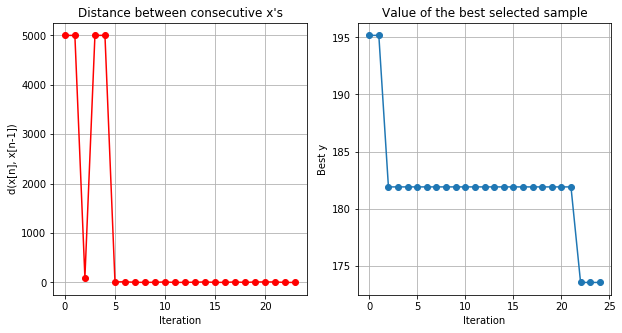

In [16]:
optimizer.plot_convergence()

In [17]:
optimizer.Y

array([[195.17756611],
       [284.44060835],
       [181.90454579],
       [234.50233546],
       [334.65983259],
       [185.23110208],
       [367.16247544],
       [224.87508606],
       [191.12141146],
       [221.80092776],
       [239.34866278],
       [190.32949793],
       [188.25297356],
       [320.99991819],
       [250.42066833],
       [199.52612322],
       [366.15636833],
       [220.57159119],
       [186.93239925],
       [221.03602815],
       [185.54150416],
       [239.51101081],
       [173.53633269],
       [277.46237054],
       [214.78729432]])